In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
from pathlib import Path
import shutil

# Step 1: Extract the zip
zip_path = "/content/archive.zip"
extract_to = "/content/dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Step 2: Create binary dataset structure
original_path = Path(extract_to) / "garbage_classification"
binary_path = Path("/content/plastic_binary_dataset")
plastic_path = binary_path / "plastic"
not_plastic_path = binary_path / "not_plastic"

plastic_path.mkdir(parents=True, exist_ok=True)
not_plastic_path.mkdir(parents=True, exist_ok=True)

# Step 3: Copy plastic class
for file in (original_path / "plastic").glob("*"):
    shutil.copy(file, plastic_path)

# Step 4: Copy other classes to not_plastic
for folder in original_path.iterdir():
    if folder.name != "plastic" and folder.is_dir():
        for file in folder.glob("*"):
            new_name = f"{folder.name}_{file.name}"
            shutil.copy(file, not_plastic_path / new_name)

print("✅ Dataset ready: plastic vs not_plastic")


✅ Dataset ready: plastic vs not_plastic


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Image and training config
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 1
DATA_DIR = "/content/plastic_binary_dataset"

# Data preparation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)

# Save the model
model.save("/content/plastic_classifier.h5")


Found 12412 images belonging to 2 classes.
Found 3103 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


388/388 ━━━━━━━━━━━━━━━━━━━━ 341s 871ms/step - accuracy: 0.9399 - loss: 0.2531 - val_accuracy: 0.9442 - val_loss: 0.1567


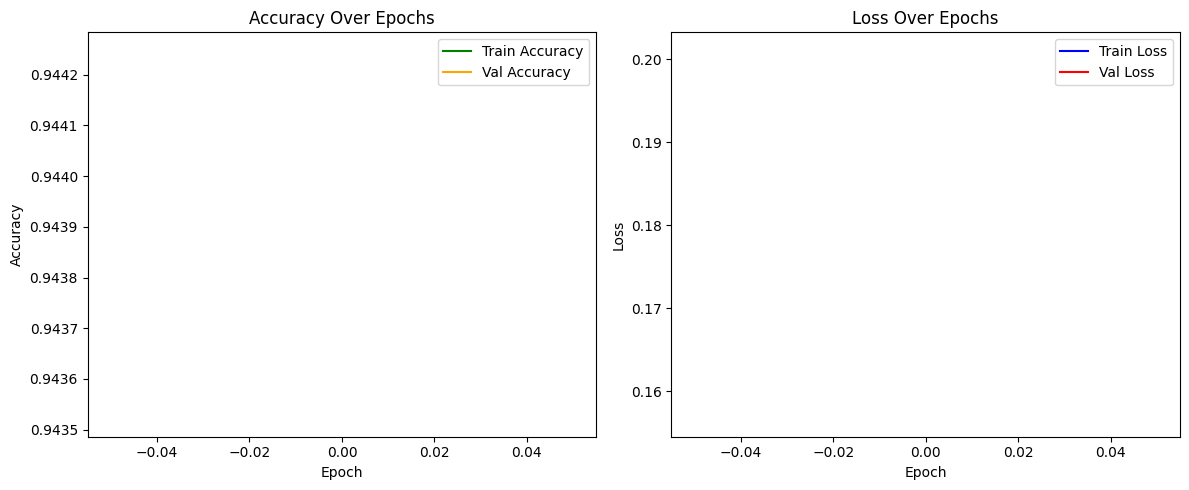

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='red')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()



97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 323ms/step
✅ Final Accuracy: 94.42%

📄 Classification Report:
              precision    recall  f1-score   support

 not_plastic       0.94      1.00      0.97      2930
     plastic       0.00      0.00      0.00       173

    accuracy                           0.94      3103
   macro avg       0.47      0.50      0.49      3103
weighted avg       0.89      0.94      0.92      3103



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


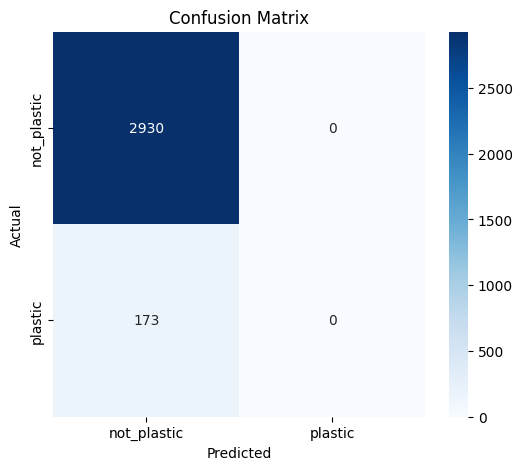

In [ ]:
# Predictions
val_data.reset()
preds = model.predict(val_data)
pred_classes = (preds > 0.5).astype("int32").flatten()
true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

# Accuracy & confusion
cm = confusion_matrix(true_classes, pred_classes)
acc = accuracy_score(true_classes, pred_classes)

print(f"✅ Final Accuracy: {acc * 100:.2f}%\n")
print("📄 Classification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [ ]:
# Imports
from IPython.display import display # Still needed for displaying Javascript if you uncomment the display line later
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from PIL import Image
import io
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Webcam function
def capture_photo(filename='captured_image.jpg'):
    # Pass the JavaScript code as a string directly to eval_js
    js_code = '''
    async function capturePhoto() {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = '📸 Capture Photo';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize output to fit video
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for capture
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      div.remove();

      return canvas.toDataURL('image/jpeg', 0.8);
    }
    capturePhoto();
    '''

    # Use eval_js with the raw string
    data = eval_js(js_code)
    binary = b64decode(data.split(',')[1])
    img = Image.open(io.BytesIO(binary))
    img.save(filename)
    print(f"📷 Image captured and saved to: {filename}")

# Predict function
def predict_captured_image(img_path, model):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)[0][0]

    print("🔍 Prediction Result:")
    if prediction > 0.5:
        print(f"✅ Detected: Plastic ({prediction:.2f}) → Goes to Plastic Bin 🗑️")
    else:
        print(f"❌ Not Plastic ({prediction:.2f}) → Not Detected")

# Load your trained model (adjust path if needed)
model = load_model("/content/plastic_classifier.h5")

# Run webcam and predict
capture_photo("captured_image.jpg")
predict_captured_image("captured_image.jpg", model)

📷 Image captured and saved to: captured_image.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
🔍 Prediction Result:
❌ Not Plastic (0.02) → Not Detected
